In [1]:
#https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [94]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tqdm'

In [66]:
df = pd.read_csv('Consumer_Complaints.csv')
print(df.head(5))
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


  Date received                                            Product  \
0    01/29/2019                                    Debt collection   
1    01/29/2019  Credit reporting, credit repair services, or o...   
2    01/29/2019                                    Debt collection   
3    01/29/2019                                    Debt collection   
4    01/29/2019  Credit reporting, credit repair services, or o...   

        Sub-product                                              Issue  \
0      Medical debt                    Written notification about debt   
1  Credit reporting  Problem with a credit reporting company's inve...   
2        Other debt                  Attempts to collect debt not owed   
3        Other debt                  Attempts to collect debt not owed   
4  Credit reporting  Problem with a credit reporting company's inve...   

                                           Sub-issue  \
0   Didn't receive enough information to verify debt   
1         Problem with

In [67]:
df.head(5)

,narrative,Product
155,My mortgage switched mortgage servicers. Previ...,Mortgage
290,"Explanation of complaint : This XXXX office, ...",Debt collection
319,There are many mistakes appear in my report wi...,"Credit reporting, credit repair services, or o..."
325,They are failing to validate debt in which the...,Debt collection
327,I had a medical debt that should have been pai...,Debt collection


In [68]:
df = df.iloc[:7500]
df.shape

(7500, 2)

In [69]:
df.index = range(7500)
df.head()

,narrative,Product
0,My mortgage switched mortgage servicers. Previ...,Mortgage
1,"Explanation of complaint : This XXXX office, ...",Debt collection
2,There are many mistakes appear in my report wi...,"Credit reporting, credit repair services, or o..."
3,They are failing to validate debt in which the...,Debt collection
4,I had a medical debt that should have been pai...,Debt collection


In [70]:
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

1367006

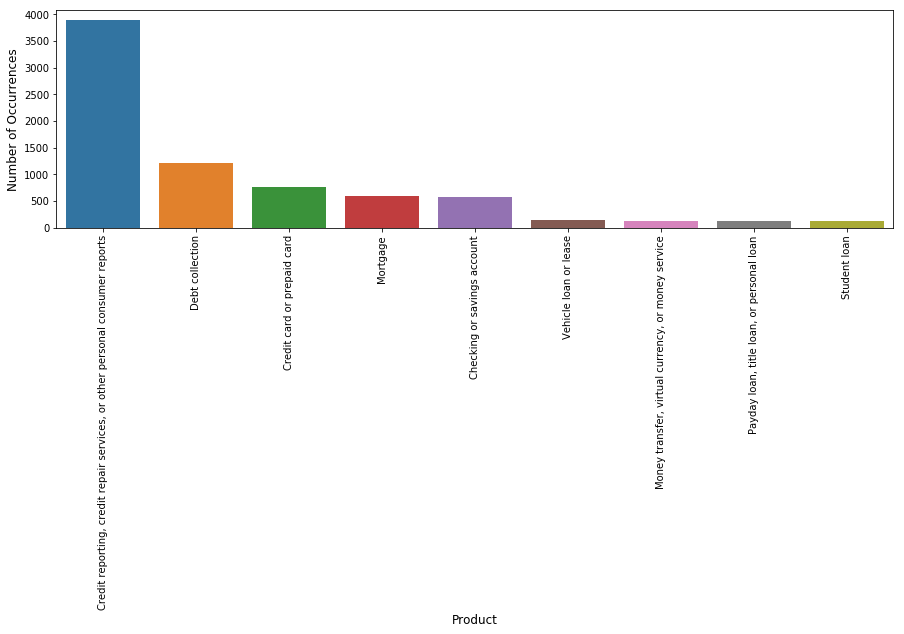

In [71]:
cnt_pro = df['Product'].value_counts()

plt.figure(figsize=(15,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=1)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [72]:
print(cnt_pro)

Credit reporting, credit repair services, or other personal consumer reports    3882
Debt collection                                                                 1202
Credit card or prepaid card                                                      761
Mortgage                                                                         592
Checking or savings account                                                      573
Vehicle loan or lease                                                            134
Money transfer, virtual currency, or money service                               122
Payday loan, title loan, or personal loan                                        119
Student loan                                                                     115
Name: Product, dtype: int64


In [73]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [74]:
print_complaint(0)

My mortgage switched mortgage servicers. Previously I had your standard mortgage due on the first of the month with the 15 day grace period which wasn't great but doable with my income schedule. Now that the mortgage servicer has switched ; they charge me to make a payment online on their website, and they also charge me late fees after only a couple days from the XXXX of the month. So, I went from always being current on my mortgage to always being late and charged fees on a monthly basis. I never would have agreed to a mortgage with such terms and I had/have no control over my mortgage being sold to a different servicer that implements such terms. This is creating unnecessary financial hardship for me as I have two mortgages that were sold to this servicer.
Product: Mortgage


In [75]:
print(df[df.index == 0][['narrative', 'Product']].values[0])

["My mortgage switched mortgage servicers. Previously I had your standard mortgage due on the first of the month with the 15 day grace period which wasn't great but doable with my income schedule. Now that the mortgage servicer has switched ; they charge me to make a payment online on their website, and they also charge me late fees after only a couple days from the XXXX of the month. So, I went from always being current on my mortgage to always being late and charged fees on a monthly basis. I never would have agreed to a mortgage with such terms and I had/have no control over my mortgage being sold to a different servicer that implements such terms. This is creating unnecessary financial hardship for me as I have two mortgages that were sold to this servicer."
 'Mortgage']


In [76]:
from bs4 import BeautifulSoup

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    text = " ".join(filtered_sentence)
    
    return text


In [77]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

In [78]:
stop_words = set(stopwords.words('english')) 

In [79]:
df['narrative'] = df['narrative'].apply(cleanText)

In [80]:
print(df[df.index == 0][['narrative', 'Product']].values[0])

["mortgage switched mortgage servicers . previously standard mortgage due first month 15 day grace period n't great doable income schedule . mortgage servicer switched ; charge make payment online website , also charge late fees couple days month . , went always current mortgage always late charged fees monthly basis . never would agreed mortgage terms had/have control mortgage sold different servicer implements terms . creating unnecessary financial hardship two mortgages sold servicer ."
 'Mortgage']


In [81]:
df.to_excel('7500_consumer_complaints.xlsx')

In [82]:
train, test = train_test_split(df, test_size=0.3)

In [83]:
print(train,type(train))

                                              narrative  \
6751  usaa , , , az ( ) employer . reported manager ...   
3763  //18 , called citibank customer service regard...   
4020  eradicate every claim alleged yet unproven res...   
1632  ran credit first time via .. noticed charges a...   
6469  cba claimed owed { $ 180.00 } reported credit ...   
5812  second attempt bring issue someones attention ...   
6170  creditor reporting accounts invalid unverified...   
3468  original submission loan modification request ...   
664   //2018 citibank charged overdraft followed mon...   
141   deposited check electronically . full amount d...   
2241  loan serviced shellpoint transferred ( ) // . ...   
4069  hello ! , charged merchant citi card // . n't ...   
3410  eperian eperian complying good faith //2018 cr...   
5965  originally applied loan modification months ag...   
5294  //2018 received email alert eperian notifying ...   
182   recently victim identity theft drastically eff... 

In [84]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [88]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

In [91]:
print(train_tagged[0])

TaggedDocument(['mortgage', 'switched', 'mortgage', 'servicers', 'previously', 'standard', 'mortgage', 'due', 'first', 'month', '15', 'day', 'grace', 'period', "n't", 'great', 'doable', 'income', 'schedule', 'mortgage', 'servicer', 'switched', 'charge', 'make', 'payment', 'online', 'website', 'also', 'charge', 'late', 'fees', 'couple', 'days', 'month', 'went', 'always', 'current', 'mortgage', 'always', 'late', 'charged', 'fees', 'monthly', 'basis', 'never', 'would', 'agreed', 'mortgage', 'terms', 'had/have', 'control', 'mortgage', 'sold', 'different', 'servicer', 'implements', 'terms', 'creating', 'unnecessary', 'financial', 'hardship', 'two', 'mortgages', 'sold', 'servicer'], ['Mortgage'])


In [92]:
print(train_tagged.values[0])

TaggedDocument(['usaa', 'az', 'employer', 'reported', 'manager', 'legal', 'counsel', 'usaa', 'credit', 'bureau', 'report', 'shared', 'plus', 'employees', 'began', 'around', '//2018', 'supervisor', 'shared', 'cbr', 'co-workers', 'others', 'infringement', 'right', 'privacy', 'witnesses', 'many', 'work', 'usaa', 'attorney', 'general', 'witness', 'information', 'reluctant', 'file', 'charges', 'usaa', 'please', 'stand', 'privacy', 'rights', 'thank', 'also', 'appears', 'company', 'reported', 'history', 'another', 'person', "'s", 'cbr', 'namely', 'sent', 'letters', 'cbr', 'agencies', 'take', 'information', 'cbrs', 'az'], ['Credit reporting, credit repair services, or other personal consumer reports'])


In [118]:
print(len(train_tagged))

5250


In [93]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

4

In [96]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in (train_tagged.values)])

In [97]:
model_dbow

In [102]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in (train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [108]:
print(model_dbow.docvecs.doctags,type(model_dbow.docvecs.doctags))

{'Credit reporting, credit repair services, or other personal consumer reports': Doctag(offset=0, word_count=168948, doc_count=2733), 'Credit card or prepaid card': Doctag(offset=1, word_count=63910, doc_count=520), 'Debt collection': Doctag(offset=2, word_count=61026, doc_count=830), 'Student loan': Doctag(offset=3, word_count=8205, doc_count=75), 'Mortgage': Doctag(offset=4, word_count=60460, doc_count=421), 'Checking or savings account': Doctag(offset=5, word_count=46923, doc_count=398), 'Money transfer, virtual currency, or money service': Doctag(offset=6, word_count=8658, doc_count=76), 'Vehicle loan or lease': Doctag(offset=7, word_count=10265, doc_count=102), 'Payday loan, title loan, or personal loan': Doctag(offset=8, word_count=7310, doc_count=95)} <class 'dict'>


In [109]:
for key in model_dbow.docvecs.doctags:
    print(key)

Credit reporting, credit repair services, or other personal consumer reports
Credit card or prepaid card
Debt collection
Student loan
Mortgage
Checking or savings account
Money transfer, virtual currency, or money service
Vehicle loan or lease
Payday loan, title loan, or personal loan


In [111]:
type(model_dbow.docvecs.doctags['Mortgage'])

gensim.models.doc2vec.Doctag

In [112]:
print(model_dbow.docvecs.offset2doctag)

['Credit reporting, credit repair services, or other personal consumer reports', 'Credit card or prepaid card', 'Debt collection', 'Student loan', 'Mortgage', 'Checking or savings account', 'Money transfer, virtual currency, or money service', 'Vehicle loan or lease', 'Payday loan, title loan, or personal loan']


In [115]:
model_dbow.docvecs[8]

array([ 6.61265135e-01, -7.49917567e-01,  1.04127061e+00,  6.38283670e-01,
       -9.57075298e-01,  8.81998479e-01,  9.87510502e-01,  7.79674828e-01,
        4.60139990e-01, -3.56154025e-01, -1.58834770e-01, -2.10168570e-01,
       -9.00713354e-02, -8.28206062e-01, -1.29504144e+00, -3.86685610e-01,
        3.76208574e-01,  4.25808340e-01,  1.91399425e-01,  2.37975061e-01,
        3.21178317e-01,  2.81038642e-01, -7.74742961e-01,  2.61643510e-02,
        1.41207188e-01,  2.37323195e-01, -3.25169742e-01,  2.24320054e-01,
       -1.15341701e-01, -1.27536166e+00, -1.49673462e-01,  9.07940328e-01,
        1.17037487e+00,  5.49259007e-01, -4.42554206e-01, -1.33278930e+00,
       -2.90994376e-01, -5.04024267e-01, -7.77175665e-01, -1.21488005e-01,
        6.97911009e-02,  8.69142294e-01,  2.57026311e-02,  1.10424526e-01,
        3.48031789e-01,  3.85266483e-01,  1.76889092e-01,  2.49590371e-02,
        5.23452818e-01,  8.07116151e-01,  9.96944547e-01, -3.73361498e-01,
        2.68860787e-01, -

In [129]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    #print(model, tagged_docs, tagged_docs.values, sents)
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [130]:
#samp_y, samp_x = vec_for_learning(model_dbow, train_tagged[:2])

In [131]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} -c mndrake xgboost

In [141]:
from sklearn import svm

classifier = xgboost.XGBClassifier() #svm.SVC()
feature_vector_train = X_train
label = y_train
feature_vector_valid = X_test

NameError: name 'xgboost' is not defined

In [137]:
import sklearn.metrics

classifier.fit(feature_vector_train, label)
predictions = classifier.predict(feature_vector_valid)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [140]:
print(sklearn.metrics.accuracy_score(predictions, y_test))
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, predictions))
print('Testing F1 score: {}'.format(f1_score(y_test, predictions, average='weighted')))

0.708
Testing accuracy 0.708
Testing F1 score: 0.6620674410314155


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
